In [1]:
import numpy as np
import cv2
import json

from scipy.optimize import minimize
from scipy.optimize import least_squares


import time
from IPython.display import clear_output

import matplotlib.pyplot as plt
import os

In [12]:
data_path = "../../Downloads/tub_10_19-12-07/"
files = os.listdir(data_path)
ims = sorted(list(filter(lambda x: "image" in x, files)))
numbers = sorted(list(map(lambda x: int(x.split("_")[0].split(".")[0]), ims)))

In [13]:
records = sorted(list(filter(lambda x: "record" in x, files)))
record_numbers = sorted(list(map(lambda x: int(x.split("_")[1].split(".")[0]), records)))

In [14]:
record_dict = {}
for i in record_numbers:
    with open(data_path + "record_{}.json".format(i)) as f:
        d = json.loads(f.read())
        if d["cam/image_array"] in ims:
            record_dict[i] = {"im": d["cam/image_array"], "t": d["milliseconds"]}
        

In [15]:
mtx = np.array([[172.41918421,   0.        , 197.09652136],
       [  0.        , 172.91896919, 158.59453644],
       [  0.        ,   0.        ,   1.        ]])

dist = np.array([[-0.1986184 ,  0.05380571,  0.00986438, -0.01136837, -0.00430709]])

# Optimize

In [18]:
def RPsiTheta(psi, theta):
    return np.array([[np.cos(theta), 0, np.sin(theta)],
                    [np.sin(psi) * np.sin(theta), np.cos(psi), -np.sin(psi) * np.cos(theta)],
                    [-np.cos(psi) * np.sin(theta), np.sin(psi), np.cos(psi) * np.cos(theta)]])

def RT(phi, tx, ty):
    return np.array([[np.cos(phi), -np.sin(phi), tx], [np.sin(phi), np.cos(phi), ty], [0, 0, 1]])

def K(f, px, py):
    return np.array([[f, 0, px], [0, f, py], [0, 0, 1]])

In [19]:
total = 0
def objective(x, f1, f2):
    global total
    f = x[0]
    px = x[1]
    py = x[2]
    psi = x[3]
    theta = x[4]
    points = x[5:]
    
    K_mat = K(f, px, py)
    K_inv = np.linalg.inv(K_mat)
    R1 = RPsiTheta(psi, theta)
    
    total = 0
    
    for i in range(len(points) // 3):
        R2 = RT(points[3 * i], points[3 * i + 1], points[3 * i + 2])
        target = f2.T
        new_H = K_mat @ R1 @ R2 @ R1.T @ K_inv
        res = new_H.dot(f1.T)
        total += np.sum((target - res)**2)
    #clear_output(wait = True)
    #print(total)
    return total
        

In [21]:
constants =  np.array([172.4, 197.1, 158.6, 0, 0.61])
points = np.array([0, 1, 0] * len(features))

x0 = np.hstack((constants, points))
x0 = points

In [23]:
counter = 1
def callbackF(Xi):
    global counter
    global total
    clear_output(wait = True)
    print("Counter: {}, Total: {}, Parameters: {}".format(counter, total, " ".join([str(i) for i in Xi[:5]])))
    
    counter += 1

In [24]:
def optimize(points, H):
    x0 = np.array([0, 1, 0])
    res = least_squares(objective2, x0, verbose=2, x_scale='jac', ftol=1e-4, method='trf', args=(H, points))
    return res

In [25]:
def RPsiTheta(psi, theta):
    return np.array([[np.cos(theta), 0, np.sin(theta)],
                    [np.sin(psi) * np.sin(theta), np.cos(psi), -np.sin(psi) * np.cos(theta)],
                    [-np.cos(psi) * np.sin(theta), np.sin(psi), np.cos(psi) * np.cos(theta)]])

def RT(phi, tx, ty):
    return np.array([[np.cos(phi), -np.sin(phi), tx], [np.sin(phi), np.cos(phi), ty], [0, 0, 1]])

def K(f, px, py):
    return np.array([[f, 0, px], [0, f, py], [0, 0, 1]])

def RH(psi, theta, f, px, py, phi, tx, ty):
    k = K(f, px, py)
    r1 = RPsiTheta(psi, theta)
    r2 = RT(phi, tx, ty)
    
    H = k @ r1 @ r2 @ r1.T @ np.linalg.inv(k)
    
    return H

def rotate(x, phi):
    return np.array([[np.cos(phi), -np.sin(phi)],[np.sin(phi), np.cos(phi)]]).dot(x)

In [40]:
#6.25486157e+01,  2.45720685e+02, -3.77627158e+01, -1.63159884e+00,
#       -5.61319609e-02,

def objective2(x, points1, points2):
    
    #f = 6.25486157e+01
    #px = 2.45720685e+02
    #py = -3.77627158e+01
    #psi = -1.63159884e+00
    #theta = -5.61319609e-02
    
    f = 172.4
    px = 197.1
    py = 158.6
    psi = 0
    theta = -0.93
    
    points = x
    
    K_mat = K(f, px, py)
    K_inv = np.linalg.inv(K_mat)
    R1 = RPsiTheta(psi, theta)

    R2 = RT(points[0], points[1], points[2])
    target = points2.T
    new_H = K_mat @ R1 @ R2 @ R1.T @ K_inv
    res = new_H.dot(points1.T)
    
    #print(res.shape)
    #print(target.shape)
    total = np.sqrt(np.sum((target - res)**2))

    return total

In [41]:
def optimize(points1, points2):
    x0 = np.array([0, 0.1, 0.1])
    res = least_squares(objective2, x0, verbose=0, x_scale='jac', ftol=1e-8, method='trf', args=(points1, points2))
    return res

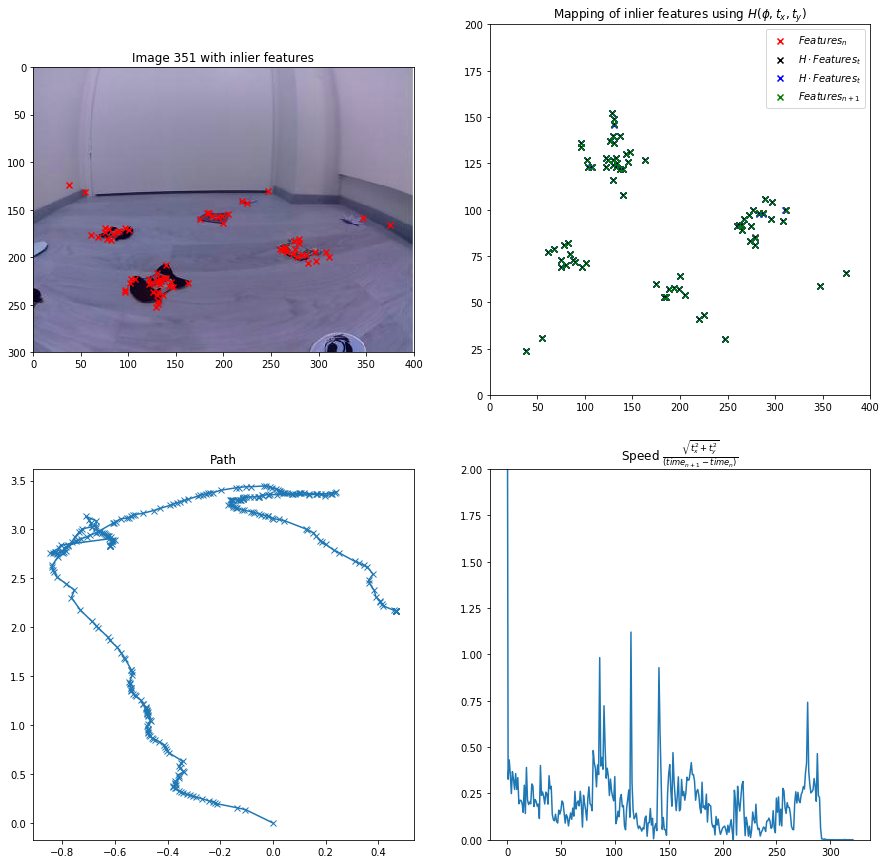

         479379142 function calls (463173629 primitive calls) in 760.034 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      966   84.553    0.088   84.553    0.088 {built-in method matplotlib._png.write_png}
  7375245   28.590    0.000   28.590    0.000 {method 'reduce' of 'numpy.ufunc' objects}
 11322683   27.455    0.000   27.457    0.000 {built-in method numpy.array}
   337455   17.439    0.000   17.439    0.000 {method 'set_text' of 'matplotlib.ft2font.FT2Font' objects}
2662940/3220   11.746    0.000   50.242    0.016 pyparsing.py:1821(_parseCache)
  5734937   11.603    0.000   37.258    0.000 fromnumeric.py:69(_wrapreduction)
 16746333   10.832    0.000   14.168    0.000 __init__.py:810(__getitem__)
16911304/13682006   10.706    0.000   16.905    0.000 artist.py:219(stale)
  2391758   10.253    0.000   10.253    0.000 {built-in method numpy.dot}
   351224    9.275    0.000   75.365    0.000 lines.py:273(__init__)
  

In [44]:
%%prun
data_path = "../../Downloads/tub_10_19-12-07/"
counter = 1
cur_t = np.zeros((3))
cur_R = np.eye(3)
cur_phi = 0

min_features = 10

path = [cur_t.T]
n_points = []
homographies = []
features = []

in1 = []
in2 = []
speeds = []

crop = 100

p1 = data_path + str(numbers[counter]) + "_cam-image_array_.jpg" 
img = cv2.imread(p1,0)#[100:,:]
img = cv2.undistort(img, mtx, dist, None)[crop:,:]

#numbers = [144, 146]

#numbers = numbers[:50]
detector = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
points = detector.detect(img)
points = np.array([x.pt for x in points], dtype=np.float32)# + np.stack((np.ones(len(points)) * 100, np.zeros(len(points))), axis = 1)
prev_img = img

ims = [record_dict[f]["im"] for f in record_dict]
times = [record_dict[f]["t"] for f in record_dict]


for i in range(30, len(ims)):
    im = ims[i]
    
    #clear_output(wait = True)
    print(i)
    #path.append(cur_t[:2])

    counter += 1

    p = data_path + im
    img = cv2.imread(p, 0)#[100:,:]
    img = cv2.undistort(img, mtx, dist, None)[crop:,:]

    new_points, st, err = cv2.calcOpticalFlowPyrLK(prev_img, img, points, None)
    n_points.append(len(points))
    st = st.squeeze()

    kp2 = points[st == 1]
    kp3 = new_points[st == 1]

    #E, mask = cv2.findEssentialMat(kp3, kp2, method = cv2.RANSAC, prob=0.999, threshold=1.0)
    H, mask = cv2.findHomography(kp2, kp3, method = cv2.RANSAC, ransacReprojThreshold=1)
    
    inliers2 = kp2[mask.squeeze() == 1]
    inliers3 = kp3[mask.squeeze() == 1]
    
    res = optimize(np.hstack((inliers2, np.ones((len(inliers2), 1)))), np.hstack((inliers3, np.ones((len(inliers3), 1)))))
    
    inliers1 = np.hstack((inliers2, np.ones((len(inliers2), 1)))).T
    inliers2 = np.hstack((inliers3, np.ones((len(inliers2), 1)))).T
    
    in1.append(inliers1)
    in2.append(inliers2)
    
    t_ = res["x"][1:]
    
    speeds.append(np.sqrt(np.sum(t_**2))/ ((times[i] - times[i - 1]) / 1000))
    
    t = rotate(t_, cur_phi)
    
    ty = path[-1][2] - t[0]
    tx = path[-1][1] - t[1]
    cur_phi += res["x"][0]
    
    path.append(np.array([cur_phi, tx, ty]))
    
    if points.shape[1] < 50:
        points = detector.detect(img)
        points = np.array([x.pt for x in points], dtype=np.float32)
        prev_img = img

    path_array = np.stack(path)
    whole_img = cv2.imread(p, 1)

    plt.figure(1, (15, 15))
    plt.plot(path_array[:,1], path_array[:,2], marker = "x")
    

    if type(H) != type(None):
        homographies.append(H)
        features.append(np.hstack((kp3, np.ones((len(kp3), 1)))))
    

    path_array = np.stack(path)
    whole_img = cv2.imread(p, 1)

    clear_output(wait = True)
    plt.figure(1, (15, 15))
    plt.subplot(2, 2, 4)
    plt.plot(speeds)
    plt.ylim(0, 2)
    plt.title("Speed $\\frac{\sqrt{t_x^2 + t_y^2}}{(time_{n+1} - time_n)}$")
    plt.subplot(2, 2, 3)
    plt.plot(path_array[:,1], path_array[:,2], marker = "x")
    plt.title("Path")
    plt.subplot(2, 2, 1)
    plt.imshow(whole_img)
    plt.title("Image {} with inlier features".format(i))
    plt.scatter(inliers2[0,:], inliers2[1,:] + crop, marker = "x", color = "r")
    plt.ylim((whole_img.shape[0]), 0)
    plt.xlim((0,whole_img.shape[1]))
    plt.subplot(2, 2, 2)
    points1 = np.hstack((kp2, np.ones((len(kp2), 1)))).T
    points2 = np.hstack((kp3, np.ones((len(kp2), 1)))).T
    
    H2 = RH(f = 172.4, px = 197.1, py = 158.6, psi = 0, theta = 0.93, phi = res["x"][0], tx = res["x"][1], ty = res["x"][2])
    
    hpoints2 = H2.dot(inliers1)
    hpoints1 = H.dot(inliers1)
    
    for j in range(inliers1.shape[1]):
        x = [inliers1[0,j], hpoints1[0, j]]
        y = [inliers1[1,j], hpoints1[1, j]]
        plt.plot(x, y, color="b")


    for j in range(inliers1.shape[1]):
        x = [inliers1[0,j], hpoints2[0, j]]
        y = [inliers1[1,j], hpoints2[1, j]]
        plt.plot(x, y, color="k")

    
    
    plt.scatter(inliers1[0,:], inliers1[1,:], marker = "x", color = "r", label = "$Features_n$")
    #plt.scatter(hpoints1[0,:], hpoints1[1,:], marker = "x", color = "b")
    plt.scatter(hpoints2[0,:], hpoints2[1,:], marker = "x", color = "k", label = "$H \cdot Features_t$")
    plt.scatter(hpoints1[0,:], hpoints1[1,:], marker = "x", color = "b", label = "$H \cdot Features_t$")
    
    plt.scatter(inliers2[0,:], inliers2[1,:], marker = "x", color = "g", label = "$Features_{n+1}$")
    plt.ylim((0, whole_img.shape[0] - crop))
    plt.xlim((0,whole_img.shape[1]))
    plt.legend(loc="upper right")
    plt.title("Mapping of inlier features using $H(\phi, t_x, t_y)$")
    plt.savefig("homographyvideo/{}_image".format(i))

    plt.show()
    #input()

    if points.shape[1] < 50:
        points = detector.detect(img)
        points = np.array([x.pt for x in points], dtype=np.float32)
        prev_img = img

In [ ]:
def RPsiTheta(psi, theta):
    return np.array([[np.cos(theta), 0, np.sin(theta)],
                    [np.sin(psi) * np.sin(theta), np.cos(psi), -np.sin(psi) * np.cos(theta)],
                    [-np.cos(psi) * np.sin(theta), np.sin(psi), np.cos(psi) * np.cos(theta)]])

def RT(phi, tx, ty):
    return np.array([[np.cos(phi), -np.sin(phi), tx], [np.sin(phi), np.cos(phi), ty], [0, 0, 1]])

def K(f, px, py):
    return np.array([[f, 0, px], [0, f, py], [0, 0, 1]])

In [ ]:
total = 0
def objective(x, f1, f2):
    global total
    f = x[0]
    px = x[1]
    py = x[2]
    psi = x[3]
    theta = x[4]
    points = x[5:]
    
    K_mat = K(f, px, py)
    K_inv = np.linalg.inv(K_mat)
    R1 = RPsiTheta(psi, theta)
    
    total = 0
    
    for i in range(len(points) // 3):
        R2 = RT(points[3 * i], points[3 * i + 1], points[3 * i + 2])
        target = f2[i]
        new_H = K_mat @ R1 @ R2 @ R1.T @ K_inv
        res = new_H.dot(f1[i])
        total += np.sum((target - res)**2)
    #clear_output(wait = True)
    #print(total)
    return total
        

In [776]:
constants =  np.array([172.4, 197.1, 158.6, 0, 0.61])
constants =  np.array([7.00806145e+01,  2.29150654e+02, -3.27014379e+01, -1.56420881e+00, -4.87758411e-02])
points = np.array([0, 0.1, 0.1] * len(in1))

x0 = np.hstack((constants, points))

In [777]:
counter = 1
def callbackF(Xi):
    global counter
    global total
    clear_output(wait = True)
    print("Counter: {}, Total: {}, Parameters: {}".format(counter, total, " ".join([str(i) for i in Xi[:5]])))
    
    counter += 1

In [778]:
counter = 1
res = least_squares(objective, x0, verbose=2, x_scale='jac', max_nfev = None, method='trf', args=(in1, in2))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1625e+11                                    1.68e+12    
       1              5         3.2931e+11      8.69e+10       1.25e+00       1.27e+12    
       2              6         2.2930e+11      1.00e+11       1.27e+00       9.98e+11    
       3              7         1.1994e+11      1.09e+11       2.47e+00       6.31e+11    
       4              8         8.5756e+10      3.42e+10       4.41e+00       8.73e+11    
       5              9         5.2203e+10      3.36e+10       2.03e+00       2.71e+11    
       6             11         4.0558e+10      1.16e+10       5.37e-01       2.30e+11    
       7             12         3.5167e+10      5.39e+09       1.16e+00       1.99e+11    
       8             13         3.2206e+10      2.96e+09       9.95e-01       1.75e+11    
       9             14         2.8602e+10      3.60e+09       8.68e-01       1.53e+11    

In [779]:
res

 active_mask: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])
        cost: 1002065522.0932032
         fun: array([44767.52220289])
        grad: array([ 4.02498259e+06, -8.89450643e+05, -6.33128006e+05,  1.08218905e+07,
        2.64181717e+07,  4.14624200e+06,  1.39550728e+07,  3.13170896e+07,
        1.12574580e+04, -6.12055968e+02, -1.33996539e+04, -2.06284720e+05,
       -7.83951886e+06, -1.50324662e+07, -8.15302267e+05, -1.06024182e+08,
       -1.62712653e+08,  1.11155921e+06, -1.01650212e+08, -1.48647191e+08,
        2.29851061e+06, -6.56843129e+07, -9.71094337e+07,  1.79115993e+06,
       -9.35315790e+07, -1.26471726e+08,  3.01525001e+06, -7.94026957e+07,
       -1.07065704e+08,  3.01525001e+06, -7.94026671e+07, -1.07065704e+08,
        2.71421574e+08, -6.24844436e+06, -2.13601215e+08])
         jac: array([[ 8.99085408e+01, -1.98682125e+01, -1.41425742e+01,
       

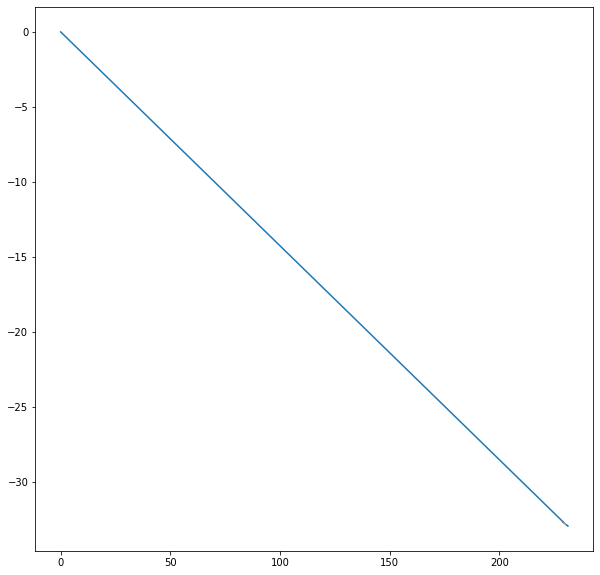

In [774]:
points = res["x"]

x = 0
y = 0
cur_phi = 0
plt.figure(1, (10, 10))
for i in range((len(points)) // 3):
    phi = points[3 * i + 0]
    next_x = x + points[3 * i + 1]
    next_y = y + points[3 * i + 2]
    plt.plot((x, next_x), (y, next_y))
    plt.draw()
    y = next_y
    x = next_x